In [71]:
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity, plot_2dsim
from tqdm import tqdm
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
X, y = generate_gaussian_parity(1000)
X_ood, y_ood = generate_gaussian_parity(1000, angle_params=np.pi/6)

<AxesSubplot: >

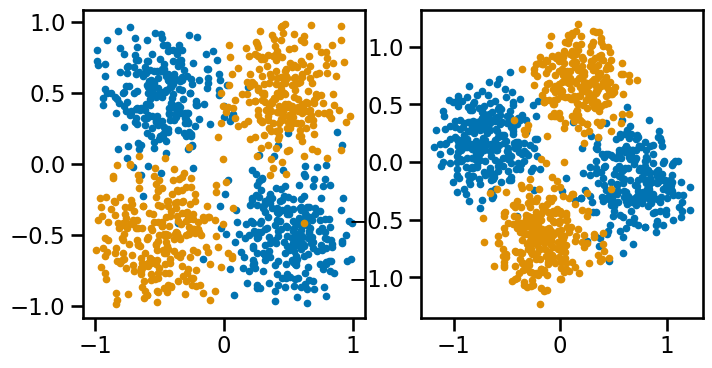

In [84]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

plot_2dsim(X,y, ax=ax[0])
plot_2dsim(X_ood,y_ood, ax=ax[1])

In [85]:
n_estimators = 100
n_seeds = 100
splitting_criteria = ['gini', 'entropy', 'log_loss']
n_criteria = len(splitting_criteria)
n_train_id = 1000
n_test_id = 1000
n_eval_ood = 1000
n_test_ood = 1000
angle = np.pi/6

In [86]:
rf_models = [[] for _ in range(n_criteria)]

x_train_id, y_train_id = generate_gaussian_parity(n_train_id)
x_test_id, y_test_id = generate_gaussian_parity(n_test_id)

x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=angle)
x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=angle)

for i in tqdm(range(n_criteria)):
    for j in range(n_seeds):
        model = rf(n_estimators=n_estimators, criterion=splitting_criteria[i], random_state=j)
        model.fit(x_train_id, y_train_id)
        rf_models[i].append(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.45s/it]


In [87]:
l_id = np.zeros((n_criteria, n_seeds), dtype=float)
l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
proba = []

for i in tqdm(range(n_criteria)):
    for j in range(n_seeds):
        proba.append(
            rf_models[i][j].predict_proba(x_eval_ood)
        )
        y_pred_id = rf_models[i][j].predict(x_test_id)
        y_pred_ood = rf_models[i][j].predict(x_test_ood)
        l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
        l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.87s/it]


In [88]:
D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

for ii in tqdm(range(n_seeds*n_criteria)):
    for jj in range(ii+1, n_seeds*n_criteria):
        D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
        D[jj,ii] = D[ii,jj]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1795.76it/s]


In [89]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(D)

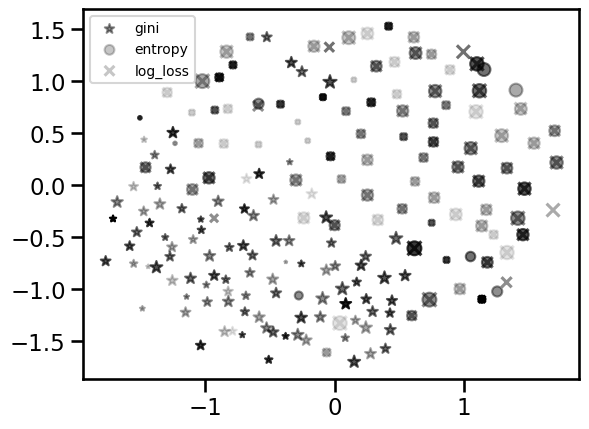

In [90]:
sns.set_context('talk')

plt.scatter(X_transformed[:100,0], X_transformed[:100,1], c='k', marker='*', s=100*(l_ood[0]-np.min(l_ood[0]))/(np.max(l_ood[0])-np.min(l_ood[0])), alpha=(l_id[0]-np.min(l_id[0]))/(np.max(l_id[0])-np.min(l_id[0])), label=splitting_criteria[0])
plt.scatter(X_transformed[100:200,0], X_transformed[100:200,1], c='k', marker='o', s=100*(l_ood[1]-np.min(l_ood[1]))/(np.max(l_ood[1])-np.min(l_ood[1])), alpha=(l_id[1]-np.min(l_id[1]))/(np.max(l_id[1])-np.min(l_id[1])), label=splitting_criteria[1])
plt.scatter(X_transformed[200:,0], X_transformed[200:,1], c='k', marker='x', s=100*(l_ood[2]-np.min(l_ood[2]))/(np.max(l_ood[2])-np.min(l_ood[2])), alpha=(l_id[2]-np.min(l_id[2]))/(np.max(l_id[2])-np.min(l_id[2])), label=splitting_criteria[2])
plt.legend(loc='upper left', fontsize=10)
